In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

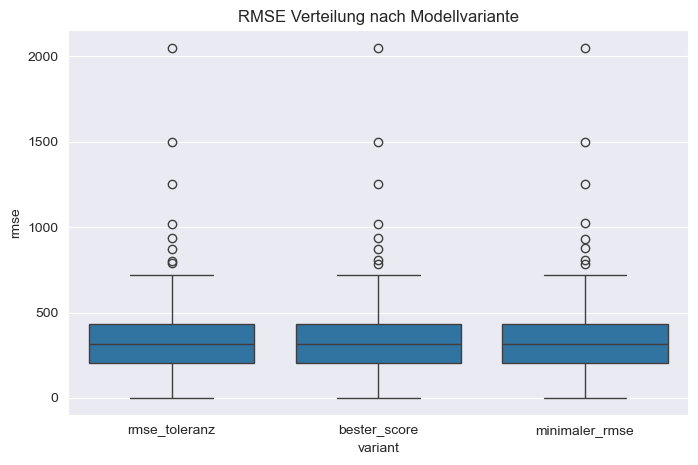

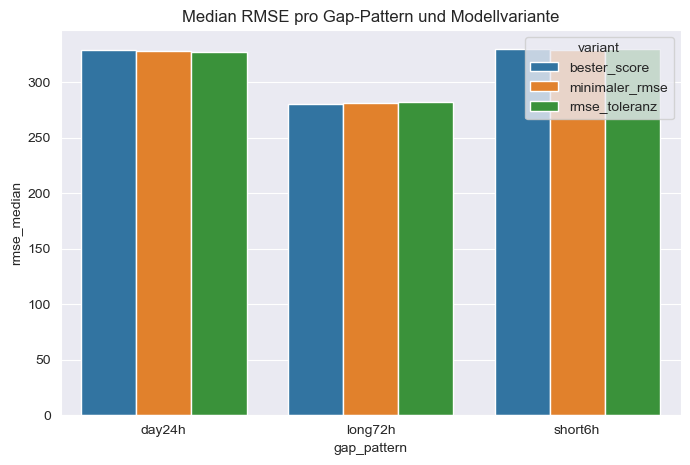

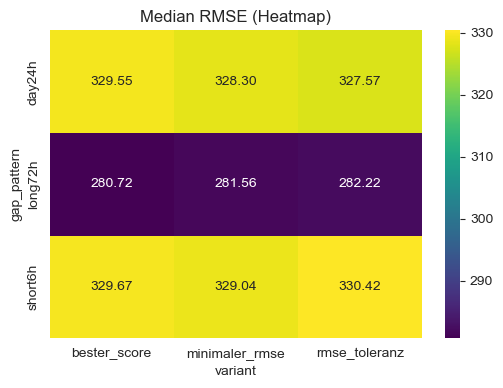

In [2]:
df = pd.read_csv("../data/experiment_results/experiment_summary.csv")

# Boxplot: RMSE nach Modellvariante
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="variant", y="rmse")
plt.title("RMSE Verteilung nach Modellvariante")
plt.show()

# Grouped Barplot: median RMSE pro Gap-Pattern + Modell
pivot = (
    df.groupby(["gap_pattern","variant"])
      .agg(rmse_median=("rmse","median"))
      .reset_index()
)
plt.figure(figsize=(8,5))
sns.barplot(data=pivot, x="gap_pattern", y="rmse_median", hue="variant")
plt.title("Median RMSE pro Gap-Pattern und Modellvariante")
plt.show()

# Heatmap
heat = pivot.pivot(index="gap_pattern", columns="variant", values="rmse_median")
plt.figure(figsize=(6,4))
sns.heatmap(heat, annot=True, fmt=".2f", cmap="viridis")
plt.title("Median RMSE (Heatmap)")
plt.show()

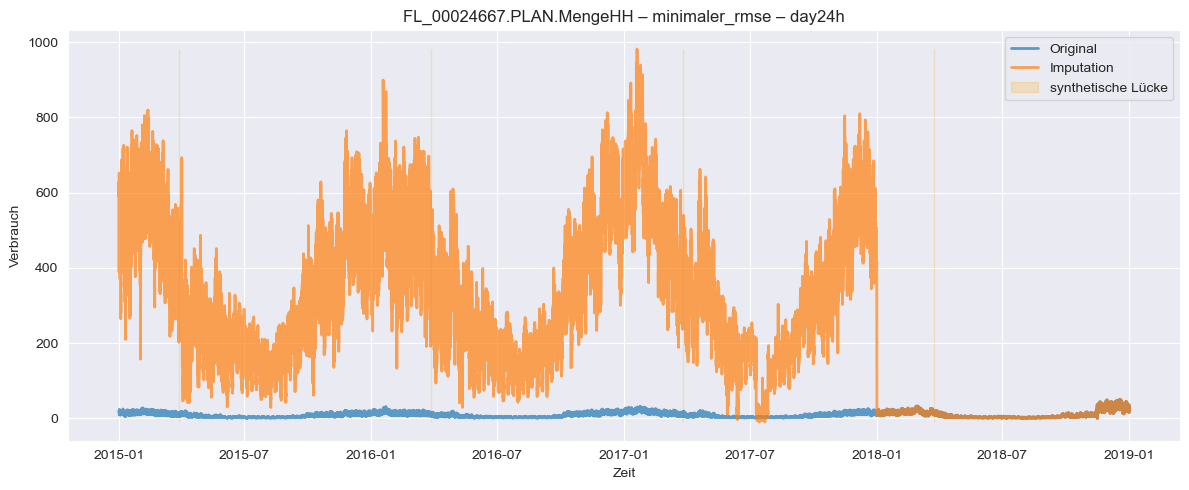

In [17]:
def plot_imputation(series_key, variant, bin_key, gap_pattern,
                    base_dir="../data/experiment_results/imputed_series",
                    target_col="consumption"):
    """
    Visualisiert Original vs. Imputation für eine Serie mit synthetischer Lücke.

    Args:
        series_key: Name der Serie (z. B. "FL_00024360.PLAN.MengeHH.2")
        variant: Modellvariante ("rmse_toleranz", "bester_score", "minimaler_rmse")
        bin_key: Bin, in dem die Serie liegt ("0–5%", "10–15%", …)
        gap_pattern: Gap-Muster ("short6h", "day24h", "long72h")
        base_dir: Basisordner für gespeicherte Imputationsergebnisse
        target_col: Name der Zielspalte (Default: "consumption")
    """
    fn = Path(base_dir) / variant / bin_key / f"{series_key}__{gap_pattern}.parquet"
    if not fn.exists():
        raise FileNotFoundError(f"Datei nicht gefunden: {fn}")

    df = pd.read_parquet(fn)

    plt.figure(figsize=(12,5))
    plt.plot(df.index, df[target_col], label="Original", alpha=0.7, lw=2)
    plt.plot(df.index, df[f"{target_col}_imputed"], label="Imputation", alpha=0.7, lw=2)

    # Gap-Bereich farblich hervorheben
    mask = df[target_col].isna()
    if mask.any():
        plt.fill_between(df.index, df[f"{target_col}_imputed"].min(),
                         df[f"{target_col}_imputed"].max(),
                         where=mask, color="orange", alpha=0.2, label="synthetische Lücke")

    plt.title(f"{series_key} – {variant} – {gap_pattern}")
    plt.xlabel("Zeit")
    plt.ylabel("Verbrauch")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Beispielaufruf:
plot_imputation(
    series_key="FL_00024667.PLAN.MengeHH",
    variant="minimaler_rmse",
    bin_key="0–5%",
    gap_pattern="day24h"
)

In [8]:
import pickle
with open("../data/series_by_bin.pkl", "rb") as f:
    series_by_bin_loaded = pickle.load(f)

<Axes: xlabel='von'>

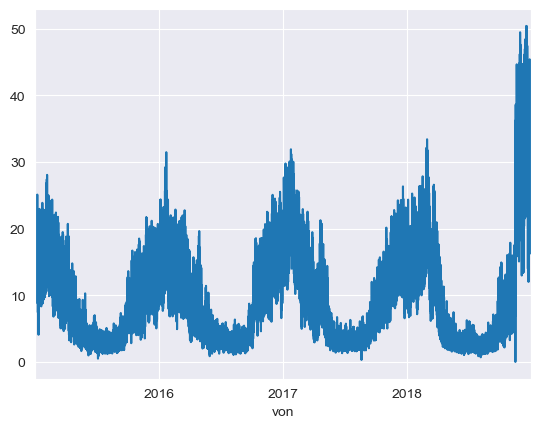

In [16]:
series_by_bin_loaded['0–5%']['FL_00024667.PLAN.MengeHH'].consumption.plot()

In [11]:
series_by_bin_loaded['0–5%']['FL_00024360.PLAN.MengeHH.2'].isna().sum()

consumption    4
w_tl           0
w_rf           0
w_ff           0
w_ffx          0
w_cglo         0
w_so_h         0
w_rr           0
w_rrm          0
w_tb10         0
w_tb20         0
CEGH_WAP       0
THE_WAP        0
dtype: int64

In [12]:
series_by_bin_loaded['0–5%']['FL_00024360.PLAN.MengeHH.2'][series_by_bin_loaded['0–5%']['FL_00024360.PLAN.MengeHH.2'].isna().any(axis=1)]

,consumption,w_tl,w_rf,w_ff,w_ffx,w_cglo,w_so_h,w_rr,w_rrm,w_tb10,w_tb20,CEGH_WAP,THE_WAP
von,,,,,,,,,,,,,
2015-03-29 02:00:00,NaN,1.5,82,0.8,1.8,0.0,0.0,0.0,0,6.2,6.9,22.68,22.32
2016-03-27 02:00:00,NaN,2.3,91,0.6,1.7,0.0,0.0,0.0,0,6.4,6.8,12.63,12.13
2017-03-26 02:00:00,NaN,6.4,64,2.9,6.1,0.0,0.0,0.0,0,7.7,7.7,16.19,15.53
2018-03-25 02:00:00,NaN,0.4,85,3.5,6.7,0.0,0.0,0.0,0,3.6,3.4,19.14,19.64


In [13]:
series_by_bin_loaded['0–5%'].keys()

dict_keys(['FL_00024360.PLAN.MengeHH.2', 'FL_00024360.PLAN.MengeGA', 'FL_00352244.PLAN.MengeKW', 'FL_00352244.PLAN.MengeGA', 'FL_00352251.PLAN.MengeGA', 'FL_00352254.PLAN.MengeGA', 'FL_00342704.PLAN.MengeGA', 'FL_00025248.PLAN.MengeGA', 'FL_00352208.PLAN.MengeGA', 'FL_00352054.PLAN.MengeHH', 'CV_00348266.PLAN.Menge', 'FL_00025240.PLAN.MengeHH', 'FL_00025241.PLAN.MengeHH', 'FL_00352218.PLAN.MengeHH', 'FL_00024667.PLAN.MengeHH', 'FL_00352255.PLAN.MengeHH', 'FL_00024673.PLAN.MengeHH', 'FL_00020896.PLAN.MengeHH', 'FL_00024679.PLAN.MengeHH', 'FL_00024741.PLAN.MengeHH', 'FL_00024731.PLAN.MengeHH', 'FL_00024735.PLAN.MengeHH', 'FL_00024730.PLAN.MengeHH', 'FL_00024745.PLAN.MengeHH', 'FL_00352243.PLAN.MengeHH', 'FL_00024702.PLAN.MengeHH', 'FL_00024725.PLAN.MengeHH', 'FL_00024728.PLAN.MengeHH', 'FL_00024727.PLAN.MengeHH', 'FL_00352244.PLAN.MengeHH', 'FL_00352254.PLAN.MengeHH', 'FL_00342704.PLAN.MengeHH', 'FL_00352208.PLAN.MengeHH', 'FL_00352430.PLAN.MengeHH', 'FL_00352191.PLAN.MengeHH', 'FL_00352